In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,TensorDataset
from gensim.models import Word2Vec
from models import RNNcVAE, GRUcVAE, LSTMcVAE, CNNClassifier
from config_dataset import custom_dataset
from accuracy import style_accuracy
from training_function import training, train_CNN

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
sequence_length = 30
batch_size = 128
embedding_dim = 300
hidden_dim = 128
latent_dim = 100

In [13]:
train_loader, val_loader, embedding_dim, embedding_matrix, word2vec, idx2word, word2idx, vocab_size = custom_dataset('text_corpus/divina_commedia.txt',
                                                                                                                     'text_corpus/uno_nessuno_e_i_malavoglia.txt',
                                                                                                                     'text_corpus/lo_cunto_de_li_cunti.txt',
                                                                                                                    sequence_length,
                                                                                                                    embedding_dim,
                                                                                                                    batch_size,
                                                                                                                    0.9)

print('total number of training samples: ', len(train_loader.dataset))
print('total number of validation samples: ', len(val_loader.dataset))
print('vocab size: ', vocab_size)

total number of training samples:  45550
total number of validation samples:  5062
vocab size:  26607


In [14]:
sos_token = torch.full((1,),word2idx['<sos>'])
sos_token = sos_token.type(torch.LongTensor)

# RNN VAE Training

In [15]:
rnn_cvae = RNNcVAE(embedding_matrix, idx2word, 3, hidden_dim, latent_dim, 2, sos_token, vocab_size)
rnn_cvae.number_parameters()

Total number of model parameters:  3648159


In [ ]:
training(rnn_cvae, train_loader, val_loader, 7, lr = 4e-4, title = 'RNN')

In [30]:
style_label = {'Dante' : torch.FloatTensor([1,0,0]), 'Italian' : torch.FloatTensor([0,1,0]), 'Neapolitan' : torch.FloatTensor([0,0,1])}

label = style_label['Italian']
sentence, perplexity = rnn_cvae.sample(label, 40, 0.7)

# GRU VAE Training

In [17]:
gru_cvae = GRUcVAE(embedding_matrix, idx2word, 3, hidden_dim, latent_dim, 2, sos_token, vocab_size)
gru_cvae.number_parameters()

Total number of model parameters:  4000415


 12%|█▎        | 1/8 [05:07<35:50, 307.20s/it]

====> Epoch: 1 Average train loss: 0.0815, Average val loss: 0.0586


 25%|██▌       | 2/8 [10:22<31:13, 312.22s/it]

====> Epoch: 2 Average train loss: 0.0549, Average val loss: 0.0551


 38%|███▊      | 3/8 [15:40<26:14, 314.82s/it]

====> Epoch: 3 Average train loss: 0.0507, Average val loss: 0.0521


 50%|█████     | 4/8 [21:02<21:09, 317.35s/it]

====> Epoch: 4 Average train loss: 0.0473, Average val loss: 0.0507


 62%|██████▎   | 5/8 [26:29<16:03, 321.10s/it]

====> Epoch: 5 Average train loss: 0.0449, Average val loss: 0.0502


 75%|███████▌  | 6/8 [31:57<10:46, 323.46s/it]

====> Epoch: 6 Average train loss: 0.0429, Average val loss: 0.0501


 88%|████████▊ | 7/8 [37:26<05:25, 325.21s/it]

====> Epoch: 7 Average train loss: 0.0412, Average val loss: 0.0502


100%|██████████| 8/8 [43:01<00:00, 322.74s/it]

====> Epoch: 8 Average train loss: 0.0397, Average val loss: 0.0505


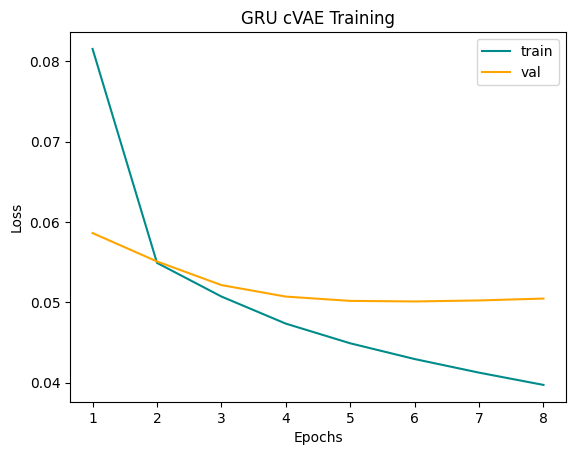

In [16]:
training(gru_cvae, train_loader, val_loader, 8, lr = 4e-4, title = 'GRU')

# GRU VAE Inference

In [18]:
style_label = {'Dante' : torch.FloatTensor([1,0,0]), 'Italian' : torch.FloatTensor([0,1,0]), 'Neapolitan' : torch.FloatTensor([0,0,1])}
label = style_label['Dante']

gru_cvae.sample(label, 40, 0.6)

'e io vidi già nè sonno a me ne li occhi miei e io per me in quel suo foco ne l acqua si sentì col capo e li occhi con l altro del suo canto e poi che di'

# LSTM VAE Training

In [35]:
lstm_cvae = LSTMcVAE(embedding_matrix, idx2word, 3, hidden_dim, latent_dim, 2, sos_token, vocab_size)
lstm_cvae.number_parameters()

Total number of model parameters:  4088479


 12%|█▎        | 1/8 [05:11<36:17, 311.00s/it]

====> Epoch: 1 Average train loss: 0.0820, Average val loss: 0.0607


 25%|██▌       | 2/8 [10:23<31:12, 312.05s/it]

====> Epoch: 2 Average train loss: 0.0567, Average val loss: 0.0566


 38%|███▊      | 3/8 [15:40<26:10, 314.10s/it]

====> Epoch: 3 Average train loss: 0.0522, Average val loss: 0.0531


 50%|█████     | 4/8 [20:59<21:04, 316.13s/it]

====> Epoch: 4 Average train loss: 0.0484, Average val loss: 0.0511


 62%|██████▎   | 5/8 [26:24<15:57, 319.26s/it]

====> Epoch: 5 Average train loss: 0.0457, Average val loss: 0.0504


 75%|███████▌  | 6/8 [31:49<10:42, 321.13s/it]

====> Epoch: 6 Average train loss: 0.0436, Average val loss: 0.0501


 88%|████████▊ | 7/8 [37:14<05:22, 322.41s/it]

====> Epoch: 7 Average train loss: 0.0418, Average val loss: 0.0502


100%|██████████| 8/8 [42:39<00:00, 319.94s/it]

====> Epoch: 8 Average train loss: 0.0402, Average val loss: 0.0504


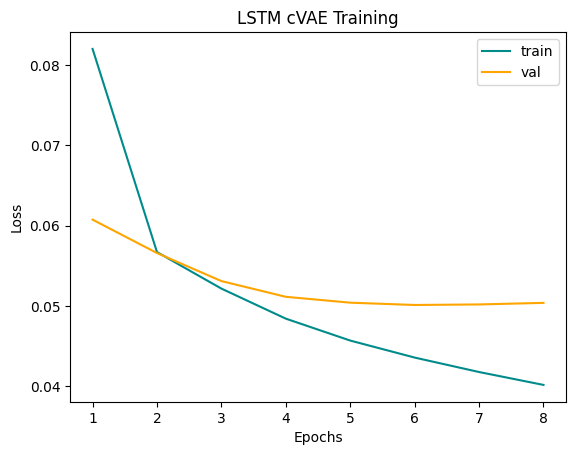

In [16]:
training(lstm_cvae, train_loader, val_loader, 8, lr = 4e-4, title = 'LSTM')

In [25]:
style_label = {'Dante' : torch.FloatTensor([1,0,0]), 'Italian' : torch.FloatTensor([0,1,0]), 'Neapolitan' : torch.FloatTensor([0,0,1])}
label = style_label['Dante']

lstm_cvae.sample(label, 40, 0.75)

'una orazion ma la fede che non se impressa chè l ciel in sua guida a miglior retroso sì che dietro a lui si move sostenea di sè fermo e per forza non di me mi disse per me m'

## Independent CNN classifier

In [28]:
CNN_classif = CNNClassifier(embedding_matrix, 3, 2, [3,3])

In [29]:
style_params = sum(p.numel() for p in CNN_classif.parameters() if p.requires_grad)
print('Total parameters: ', style_params)

Total parameters:  3619


In [31]:
wrong = 0.0
wrongy = []
with torch.no_grad():
    for i, (data, labels) in enumerate(val_loader):
        pred_style = torch.argmax(CNN_classif(data), dim=-1)
        label = torch.argmax(labels,dim=-1)
        wrong += torch.count_nonzero(label - pred_style)
        
print('Accuracy :', 1 - (wrong/(len(val_loader)*batch_size)).item(), '%')

Accuracy : 0.9921875 %


# Style Accuracy

In [40]:
style_accuracy(lstm_cvae, CNN_classif, word2idx, name = 'LSTM')

100%|██████████| 1000/1000 [01:48<00:00,  9.24it/s]

LSTM cVAE 

Dante accuracy:  0.909 

Italian accuracy:  0.977 

Neapolitan accuracy:  0.995 

Overall  LSTM  accuracy:  0.9603333333333334 

Average  LSTM  Perplexity:  38.53625834941864
